# Using RISGW

#### On random points

In [1]:
import sys
import numpy as np
import torch
sys.path.append('./lib')
from risgw import risgw_gpu
import matplotlib.pyplot as pl
from risgw import risgw_gpu
from sgw_pytorch import sgw_gpu

In [2]:
n_samples=300
Xs=np.random.rand(n_samples,1)
Xt=np.random.rand(n_samples,2)
P=np.random.randn(2,500) # 500 projections are used

In [3]:
xs=torch.from_numpy(Xs).to(torch.float32)
xt=torch.from_numpy(Xt).to(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
%%time
risgw_gpu(xs,xt,device,P=torch.from_numpy(P).to(torch.float32),max_iter=10)

CPU times: user 926 ms, sys: 88.9 ms, total: 1.01 s
Wall time: 385 ms


0.029098792001605034

#### RISGW is rotationnal invariant

In [5]:
def make_spiral(n_samples, noise=.5):
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return np.array(np.hstack((d1x,d1y)))

get_rot= lambda theta : np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

def get_data(n_samples,theta,scale=1,transla=0):
    Xs = make_spiral(n_samples=n_samples, noise=1)-transla
    Xt = make_spiral(n_samples=n_samples, noise=1)
    
    A=get_rot(theta)
    
    Xt = (np.dot(Xt,A))*scale+transla
    
    return Xs,Xt

def get_P(d,L):
    res=np.random.randn(d,L)
    res/=np.sqrt(np.sum(res**2,0,keepdims=True))
    return res

In [6]:
n_samples=300
theta=0#p.pi/2
scale=1

Xs,Xt=get_data(n_samples,theta,scale=scale,transla=10)

temp,Xt2=get_data(n_samples,np.pi/2,scale=scale)
temp,Xt22=get_data(n_samples,np.pi/4,scale=scale)
Xt2[:,0]+=70
Xt22[:,0]+=35

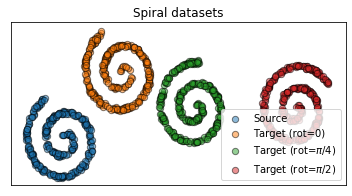

In [7]:
a=0.5
pl.figure(2,figsize=(6,3))
pl.clf()
pl.scatter(Xs[:,0],Xs[:,1],marker='o',s=40,edgecolors='k',alpha=a,label='Source')
pl.scatter(Xt[:,0],Xt[:,1],marker='o',s=40,edgecolors='k',alpha=a,label="Target (rot=0)")
pl.scatter(Xt22[:,0],Xt22[:,1],marker='o',s=40,edgecolors='k',alpha=a,label="Target (rot=$\pi/4$)")
pl.scatter(Xt2[:,0],Xt2[:,1],marker='o',s=40,edgecolors='k',alpha=a,label="Target (rot=$\pi/2$)")
pl.xticks([])
pl.yticks([])
pl.title('Spiral datasets')
pl.legend()
pl.show()

In [8]:
nbrot=10
nbloop=5
angles=np.linspace(0,np.pi/2,nbrot)
scale=1
L=20

In [9]:
SGW=np.zeros((nbloop,nbrot))
RISGW=np.zeros((nbloop,nbrot))
rota={}
fname="../res/spirale_rot2_L{}_nbloop{}_nbrot{}.npz"

In [10]:
for i in range(nbloop):
    
    P=get_P(2,L)
    Xs,Xt0=get_data(n_samples,0,scale=scale)
    
    for j,theta in enumerate(angles):
        
        A=get_rot(theta)
        Xt=Xt0.dot(A)
        xs=torch.from_numpy(Xs).to(torch.float32)
        xt=torch.from_numpy(Xt).to(torch.float32)
        P2=torch.from_numpy(P).to(torch.float32)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                        
        SGW[i,j]=sgw_gpu(xs,xt,device=device,P=P2)
                
        RISGW[i,j]=risgw_gpu(xs,xt,device=device,P=P2,max_iter=600,verbose=False)
                        
        np.savez(fname.format(L,nbloop,nbrot),angles=angles,SGW=SGW,RISGW=RISGW)
    print('!!!!!!!!!!!!!!!!{0} Loop Done!!!!!!!!!!!!!!!!'.format(i))

!!!!!!!!!!!!!!!!0 Loop Done!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!1 Loop Done!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!2 Loop Done!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!3 Loop Done!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!4 Loop Done!!!!!!!!!!!!!!!!


In [11]:
res=np.load(fname.format(L,nbloop,nbrot))     
angles=res["angles"]
SGW=res["SGW"]
RISGW=res["RISGW"]
def plot_perf(nlist,err,color,label,errbar=False,perc=20):
    pl.plot(nlist,err.mean(0),label=label,color=color)
    if errbar:
        pl.fill_between(nlist,np.percentile(err,perc,axis=0),np.percentile(err,100-perc,axis=0),
                    alpha=0.2,facecolor=color)

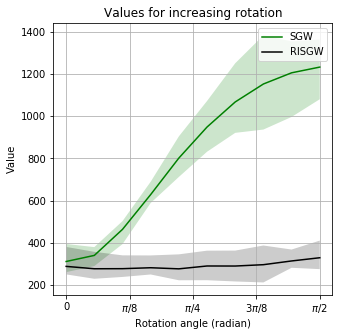

In [12]:
do_err=True
pl.figure(1,(5,5))

pl.clf()
plot_perf(angles,SGW,'g','SGW',do_err)    
plot_perf(angles,RISGW,'k','RISGW',do_err) 

pl.title("Values for increasing rotation")
pl.grid()     
pl.xlabel('Rotation angle (radian)')

pl.xticks((0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2),('0','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'))
pl.ylabel('Value')
pl.legend()